In [1]:
import os 
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from PIL import Image 

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

import random

# from posteriors import Diffusion_Coefficients, BrownianPosterior_Coefficients, get_time_schedule
from sampling_utils import extract

ASBM训练:

$x_0 \sim p_{data}$

$x_1 \sim p_{prior}$

$\varepsilon$ 是布朗桥强度

整体上分为两步

1.从$x_0$和$x_1$的联合分布中采样$(x_0, x_1)$, 然后得出条件化的布朗桥
$$
p^{W^\varepsilon}(x_{t_1}\ldots x_{t_N} | x_0, x_1) = \prod_{i=1}^{N} p^{W^\varepsilon}(x_{t_i} | x_{t_{i-1}}, x_1) \\
p^{W^\varepsilon}(x_{t_i} | x_{t_{i-1}}, x_1) = \mathcal{N}(x_{t_i}; x_{t_{i-1}} + \frac{t_i - t_{i-1}}{1 - t_{i-1}}(x_1 - x_{t_{i-1}}),\varepsilon \frac{(t_i - t_{i-1})(1 - t_i)}{(1 - t_{i-1})} I)\\
p^{W^\varepsilon}(x_{t_{i}} | x_{t_{i+1}}, x_1) = \mathcal{N}(x_{t_i}; \frac{t_{i+1}-t_{i}}{t_{i+1}} x_0 + \frac{t_{i}}{t_{i+1}} x_{t_{i+1}},\varepsilon \frac{t_i(t_{i+1} - t_{i})}{t_{i+1}} I)\\
p^{W^\varepsilon}(x_{t_N} | x_0, x_1) = \mathcal{N}(x_{t_N}; (1 - t_N) x_0 + t_N x_1, \varepsilon t_N(1 - t_N) I)
$$


In [2]:
class BrownianPosterior_Coefficients():
    def __init__(self, args, device):
        epsilon = args.epsilon
        self.epsilon = epsilon
        print(f"BrownianPosterior with epsilon {epsilon} and num steps {args.num_timesteps}")
        num_timesteps = args.num_timesteps

        t = torch.linspace(0, 1, num_timesteps+1, device=device)
        self.posterior_mean_coef1 = 1 - t[:-1]/t[1:]
        self.posterior_mean_coef2 = t[:-1]/t[1:]

        self.posterior_variance = epsilon*t[:-1]*(t[1:] - t[:-1])/t[1:]
        self.posterior_log_variance_clipped = torch.log(self.posterior_variance.clamp(min=1e-20))

In [3]:
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
import math

class Checkerboard(Dataset):
    def __init__(self, size=8, grid_size=4):
        self.size = size
        self.grid_size = grid_size
        self.checkboard = torch.tensor([[i, j] for i in range(grid_size) for j in range(grid_size) if (i + j) % 2 == 0])

        grid_pos = torch.randint(low=0, high=self.checkboard.shape[0], size=(self.size,), dtype=torch.int64)
        self.data = torch.rand(size=(self.size, 2), dtype=torch.float32) + self.checkboard[grid_pos].float()
        self.data = self.data / self.grid_size * 2 - 1

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.data[idx]


class Pinwheel(Dataset):
    def __init__(self, size: int):
        self.size = size

        radial_std = 0.3
        tangential_std = 0.1
        num_classes = 8
        num_per_class = math.ceil(size / num_classes)
        rate = 0.25
        rads = np.linspace(0, 2 * np.pi, num_classes, endpoint=False)

        features = np.random.randn(num_classes*num_per_class, 2) \
            * np.array([radial_std, tangential_std])
        features[:, 0] += 1.
        labels = np.repeat(np.arange(num_classes), num_per_class)

        angles = rads[labels] + rate * np.exp(features[:, 0])
        rotations = np.stack([np.cos(angles), -np.sin(angles), np.sin(angles), np.cos(angles)])
        rotations = np.reshape(rotations.T, (-1, 2, 2))
        x = .4 * np.random.permutation(np.einsum("ti,tij->tj", features, rotations))

        self.init_sample = torch.from_numpy(x).float()

    def __len__(self):
        return self.size

    def __getitem__(self, idx: int) -> Tensor:
        return self.init_sample[idx]


data_size = 2 ** 15
pinwheel_dataset = Pinwheel(data_size)
checkerboard_dataset = Checkerboard(size=data_size)

In [4]:
batch_size = 2 ** 10
pinwheel_data_loader = DataLoader(pinwheel_dataset, batch_size, num_workers=0, pin_memory=True, shuffle=True)
checkerboard_data_loader = DataLoader(checkerboard_dataset, batch_size, num_workers=0, pin_memory=True, shuffle=True)

def show_2d_data(data: Tensor):
    plt.figure(figsize=(3, 3))
    plt.scatter(data[:, 0], data[:, 1])
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)

    plt.show()
    plt.close()

In [5]:
pinwheel_batch = next(iter(pinwheel_data_loader))
checkerboard_batch = next(iter(checkerboard_data_loader))

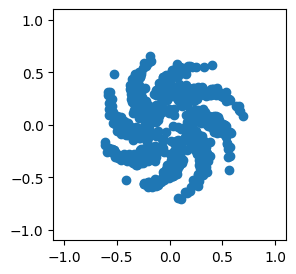

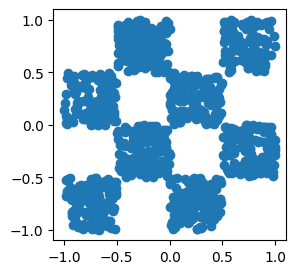

In [6]:
show_2d_data(next(iter(pinwheel_data_loader)))
show_2d_data(next(iter(checkerboard_data_loader)))

接下来需要一个统一的DataLoader，返回一个Batch的(x,y)配对数据，作为从联合分布q采样的工具

In [7]:
class PairedDataset(Dataset):
    """
    为 SB 训练提供成对样本 (x0, x1)：
      x0 ~ target_ds (p0),  x1 ~ source_ds (p1)
    pairing:
      - "independent": 每次各自随机取一个（独立耦合，默认）
      - "aligned":     用相同索引配对（便于可复现/调试）
    """
    def __init__(self, target_class, source_class, target_kwargs, source_kwargs, size, pairing="independent"):
        self.target_class = target_class
        self.source_class = source_class
        self.target_kwargs = target_kwargs
        self.source_kwargs = source_kwargs
        self.size = size
        self.pairing = pairing
        self.regenerate()
    
    def regenerate(self):
        """重新生成数据集"""
        self.target_ds = self.target_class(size=self.size, **self.target_kwargs)
        self.source_ds = self.source_class(size=self.size, **self.source_kwargs)
        print(f"Regenerated datasets with {self.size} samples each")

    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        if self.pairing == "aligned":
            i0 = idx % len(self.target_ds)
            i1 = idx % len(self.source_ds)
        else:
            i0 = random.randint(0, len(self.target_ds) - 1)
            i1 = random.randint(0, len(self.source_ds) - 1)
        
        x0 = self.target_ds[i0]
        x1 = self.source_ds[i1]
        return x0, x1

接下来的训练，我们要能做到以下几个能力
1. 给定$x_0, x_1\sim q(x_0,x_1)$ （这里直接假设独立）, 构造 $(x_t, x_{t+1})$ 作为布朗桥ground truth, 先按$q(x_{t+1}| x_0, x_1)$采样$x_{t+1}$，再按$q(x_t|x_{t+1}, x_0)$采样$x_{t}$
2. 生成器：给定$(x_t,t)$， 预测 $x_0$
3. 判别器：给定$(x_t, x_{t+1})$，判断是不是由生成器生成的

In [8]:
def sample_posterior(coefficients, x0, x_tp1, t_idx):
    """
    Brownian-bridge one-step posterior:
    Sample x_t ~ q(x_t | x_{t+1}=x_tp1, x_0=x0) for discrete index t_idx in {0,...,N-1}.
    coefficients: BrownianPosterior_Coefficients (has posterior_mean_coef1/2, posterior_log_variance_clipped)
    x0, x_tp1: (B, D)
    t_idx: (B,) int64
    """
    assert t_idx.dtype in (torch.int32, torch.int64), "t_idx must be integer indices"
    a_t = extract(coefficients.posterior_mean_coef1, t_idx, x_tp1.shape)  # coef for x0
    b_t = extract(coefficients.posterior_mean_coef2, t_idx, x_tp1.shape)  # coef for x_{t+1}
    mean = a_t * x0 + b_t * x_tp1
    log_var = extract(coefficients.posterior_log_variance_clipped, t_idx, x_tp1.shape)
    log_var = torch.clamp(log_var, min=-20)

    noise = torch.randn_like(x_tp1)
    nonzero_mask = (t_idx > 0).float().view(-1, 1)
    return mean + nonzero_mask * torch.exp(0.5 * log_var) * noise


def sample_bridge(coefficients, x0, x1, tau):
    """
    Brownian bridge marginal:
    Sample X_tau ~ N( (1-tau)x0 + tau x1,  epsilon * tau * (1 - tau) I ), where tau in [0,1].
    tau: (B,1) or (B,) float in [0,1]
    """
    if tau.ndim == 1:
        tau = tau.unsqueeze(-1)
    assert tau.dtype.is_floating_point, "tau must be float in [0,1]"
    mean = (1. - tau) * x0 + tau * x1
    var = coefficients.epsilon * tau * (1. - tau)
    log_var = torch.log(var.clamp_min(1e-20))
    noise = torch.randn_like(x0)

    # turn off noise exactly at endpoints tau=0 or tau=1
    nonzero_mask = (1. - (tau.eq(0.).float())) * (1. - (tau.eq(1.).float()))
    return mean + nonzero_mask * torch.exp(0.5 * log_var) * noise


def sample_pair_condition(coefficients, x0, x1, t_idx):
    """
    Build a real pair (x_t, x_{t+1}) given endpoints (x0, x1) and discrete index t_idx in {0,...,N-1}.
    Steps:
      1) tau_{t+1} = (t_idx+1)/N, sample x_{t+1} from bridge marginal
      2) sample x_t from one-step posterior q(x_t | x_{t+1}, x0)
    """
    assert t_idx.dtype in (torch.int32, torch.int64)
    N = coefficients.posterior_mean_coef1.shape[0]  # N steps
    tau_tp1 = (t_idx.to(torch.float32) + 1.) / float(N)  # (B,)
    x_tp1 = sample_bridge(coefficients, x0, x1, tau_tp1)           # (B, D)
    x_t   = sample_posterior(coefficients, x0, x_tp1, t_idx)       # (B, D)
    return x_t, x_tp1


现在是判别器和生成器

In [9]:
class MyGenerator(nn.Module):
    def __init__(
        self, x_dim, t_dim, n_t, z_dim, out_dim, layers,
        active=partial(nn.LeakyReLU, 0.2),
    ):
        super().__init__()

        self.x_dim = x_dim
        self.t_dim = t_dim
        self.z_dim = z_dim

        self.model_list = []
        ch_prev = x_dim + t_dim + z_dim

        self.t_transform = nn.Embedding(n_t, t_dim,)

        for ch_next in layers:
            self.model_list.append(nn.Linear(ch_prev, ch_next))
            self.model_list.append(active())
            ch_prev = ch_next

        self.model_list.append(nn.Linear(ch_prev, out_dim))
        self.model = nn.Sequential(*self.model_list)

    def forward(self, x, t, z):
        batch_size = x.shape[0]

        if z.shape != (batch_size, self.z_dim):
            z = z.reshape((batch_size, self.z_dim))

        return self.model(
            torch.cat([
                x,
                self.t_transform(t),
                z,
            ], dim=1)
        )


class MyDiscriminator(nn.Module):
    def __init__(
        self, x_dim, t_dim, n_t, layers,
        active=partial(nn.LeakyReLU, 0.2),
    ):
        super().__init__()

        self.x_dim = x_dim
        self.t_dim = t_dim

        self.model_list = []
        ch_prev = 2 * x_dim + t_dim

        self.t_transform = nn.Embedding(n_t, t_dim,)
        
        for ch_next in layers:
            # print(f"Build layer from {ch_prev} to {ch_next}")
            self.model_list.append(nn.Linear(ch_prev, ch_next))
            self.model_list.append(active())
            ch_prev = ch_next

        self.model_list.append(nn.Linear(ch_prev, 1))
        self.model = nn.Sequential(*self.model_list)

    def forward(self, x_t, t, x_tp1,):
        transform_t = self.t_transform(t)
        # print(f"x_t.shape = {x_t.shape}, transform_t = {transform_t.shape}, x_tp1 = {x_tp1.shape}")

        return self.model(
            torch.cat([
                x_t,
                transform_t,
                x_tp1,
            ], dim=1)
        ).squeeze()

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


必要的参数
1. Batch size
2. learning rate: lr_d, lr_g
3. optimizer: Adam beta1, beta2
4. epoch, 迭代次数
5. epsilon, 布朗桥强度
6. num_timesteps, 时间步数
7. x_dim, 数据维度
8. t_dim, 时间维度
9. z_dim, 隐空间维度
10. output_dir, 输出目录
11. seed, 随机种子
12. use_minibatch_ot, 是否使用minibatch OT
13. use_r1, 是否使用r1正则化
14. r1_gamma, r1正则化系数
15. lazy_reg, r1正则化的间隔
16. use_ema, 是否使用ema
17. ema_decay, ema衰减系数
18. save_ckpt, 是否保存模型
19. ckpt_interval, 保存模型的间隔
20. print, 是否打印训练情况
21. print_interval, 打印训练情况的间隔
22. vis, 是否可视化
23. vis_interval, 可视化的间隔
24. resume, 是否从断点继续训练

In [11]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def parse_args(usedefault:bool = False):
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument('--batch_size', type=int, default=2**10)
    parser.add_argument('--lr_d', type=float, default=2e-4)
    parser.add_argument('--lr_g', type=float, default=2e-4)
    parser.add_argument('--beta1', type=float, default=0.5)
    parser.add_argument('--beta2', type=float, default=0.9)
    parser.add_argument('--epoch', type=int, default=1000)
    parser.add_argument('--epsilon', type=float, default=0.25)
    parser.add_argument('--x_dim', type=int, default=2)
    parser.add_argument('--t_dim', type=int, default=6)
    parser.add_argument('--z_dim', type=int, default=2)
    parser.add_argument('--num_timesteps', type=int, default=10)
    parser.add_argument('--seed', type=int, default=42)
    parser.add_argument('--output_dir', type=str, default='./output')
    parser.add_argument('--use_minibatch_ot', action='store_true', help='whether to use minibatch OT coupling')
    parser.add_argument('--use_r1', action='store_true', help='whether to use r1 regularization')
    parser.add_argument('--r1_gamma', type=float, default=0.01, help='r1 regularization coefficient')
    parser.add_argument('--lazy_reg', type=int, default=1, help='r1 regularization interval')
    parser.add_argument('--use_ema', action='store_true', help='whether to use ema')
    parser.add_argument('--ema_decay', type=float, default=0.999, help='ema decay coefficient')
    parser.add_argument('--save_ckpt', action='store_true', help='whether to save model checkpoints')
    parser.add_argument('--print', action='store_true', help='whether to print training progress')
    parser.add_argument('--print_interval', type=int, default=100, help='interval for printing training progress')
    parser.add_argument('--vis', action='store_true', help='whether to visualize training progress')
    parser.add_argument('--vis_interval', type=int, default=1000, help='interval for visualizing training progress')
    parser.add_argument('--resume', action='store_true', help='whether to resume training from a checkpoint')

    if usedefault:
        args = parser.parse_args([])
    else:
        args = parser.parse_args()
    return args

In [12]:
def visualize_samples(netG, coefficients, args, x1, n_t, iteration, device):
    """可视化函数（提取出来避免重复代码）"""
    n_vis = min(4096, x1.size(0))
    x_vis = x1[:n_vis].clone()
    
    fig, axes = plt.subplots(1, n_t+1, figsize=((n_t+1)*2, 3))
    axes[0].scatter(x_vis[:,0].cpu(), x_vis[:,1].cpu(), s=2)
    axes[0].set_title("t=1.0")
    axes[0].set_xlim(-1.1, 1.1)
    axes[0].set_ylim(-1.1, 1.1)
    
    for i in reversed(range(n_t)):
        t_vis = torch.full((x_vis.size(0),), i, device=device, dtype=torch.long)
        z_vis = torch.randn(x_vis.size(0), args.z_dim, device=device)
        x0_pred = netG(x_vis, t_vis, z_vis)
        x_vis = sample_posterior(coefficients, x0_pred, x_vis, t_vis)
        idx = n_t - i
        axes[idx].scatter(x_vis[:,0].cpu(), x_vis[:,1].cpu(), s=2)
        axes[idx].set_title(f"t={i/n_t:.2f}")
        axes[idx].set_xlim(-1.1, 1.1)
        axes[idx].set_ylim(-1.1, 1.1)
    
    plt.suptitle(f"iter {iteration}" + (" (EMA)" if args.use_ema else ""))
    plt.tight_layout()
    plt.savefig(os.path.join(args.output_dir, f'vis_{iteration}.png'))
    plt.show()
    plt.close()

Namespace(batch_size=1024, lr_d=0.0002, lr_g=0.0002, beta1=0.5, beta2=0.9, epoch=1000, epsilon=0.25, x_dim=2, t_dim=6, z_dim=2, num_timesteps=10, seed=42, output_dir='./output', use_minibatch_ot=False, use_r1=False, r1_gamma=0.01, lazy_reg=1, use_ema=True, ema_decay=0.999, save_ckpt=True, print=True, print_interval=100, vis=True, vis_interval=1000, resume=False)
BrownianPosterior with epsilon 0.25 and num steps 10
Using EMA with decay = 0.999
=> training from scratch
Regenerated datasets with 1024000 samples each
Start training ASBM...
[Iter 100] D=1.4038 (real 0.7003 fake 0.7036) | G=0.6984
[Iter 200] D=1.3830 (real 0.6898 fake 0.6932) | G=0.6943
[Iter 300] D=1.3841 (real 0.6928 fake 0.6913) | G=0.6956
[Iter 400] D=1.3886 (real 0.6982 fake 0.6904) | G=0.6966
[Iter 500] D=1.3885 (real 0.6931 fake 0.6954) | G=0.6902
[Iter 600] D=1.3851 (real 0.6956 fake 0.6894) | G=0.6969
[Iter 700] D=1.3856 (real 0.6887 fake 0.6969) | G=0.6918
[Iter 800] D=1.3848 (real 0.6951 fake 0.6897) | G=0.6993
[I

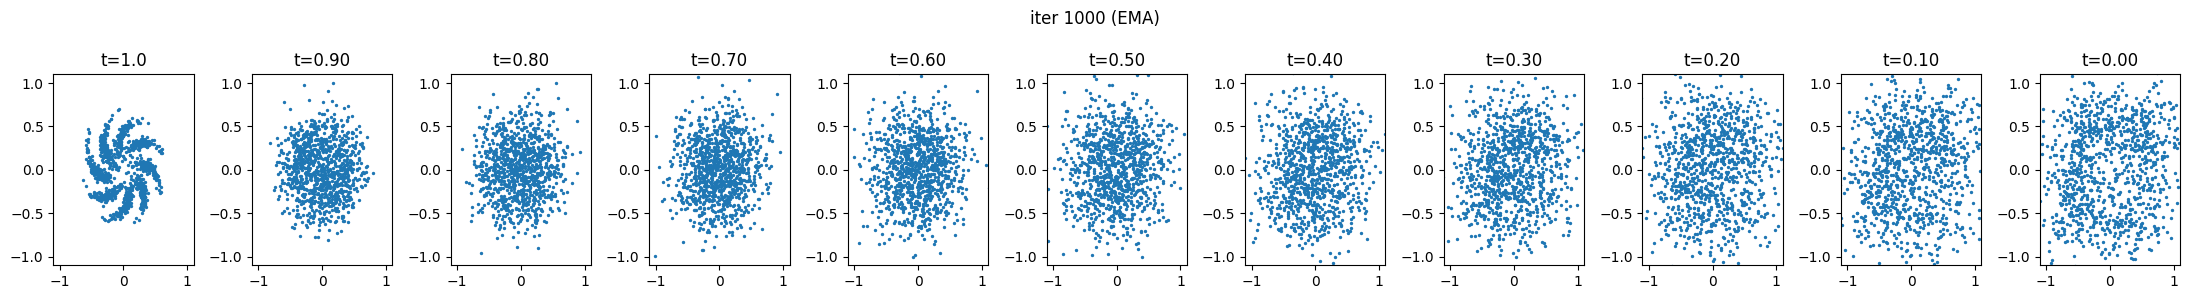

Checkpoint saved @ epoch 1
[Iter 1100] D=1.3876 (real 0.6928 fake 0.6948) | G=0.6938
[Iter 1200] D=1.3871 (real 0.6949 fake 0.6921) | G=0.6927
[Iter 1300] D=1.3858 (real 0.6929 fake 0.6928) | G=0.6937
[Iter 1400] D=1.3849 (real 0.6926 fake 0.6923) | G=0.6944
[Iter 1500] D=1.3855 (real 0.6910 fake 0.6945) | G=0.6927
[Iter 1600] D=1.3845 (real 0.6965 fake 0.6880) | G=0.6985
[Iter 1700] D=1.3869 (real 0.6909 fake 0.6960) | G=0.6932
[Iter 1800] D=1.3857 (real 0.6921 fake 0.6937) | G=0.6931
[Iter 1900] D=1.3845 (real 0.6909 fake 0.6936) | G=0.6908
[Iter 2000] D=1.3868 (real 0.6924 fake 0.6944) | G=0.6931


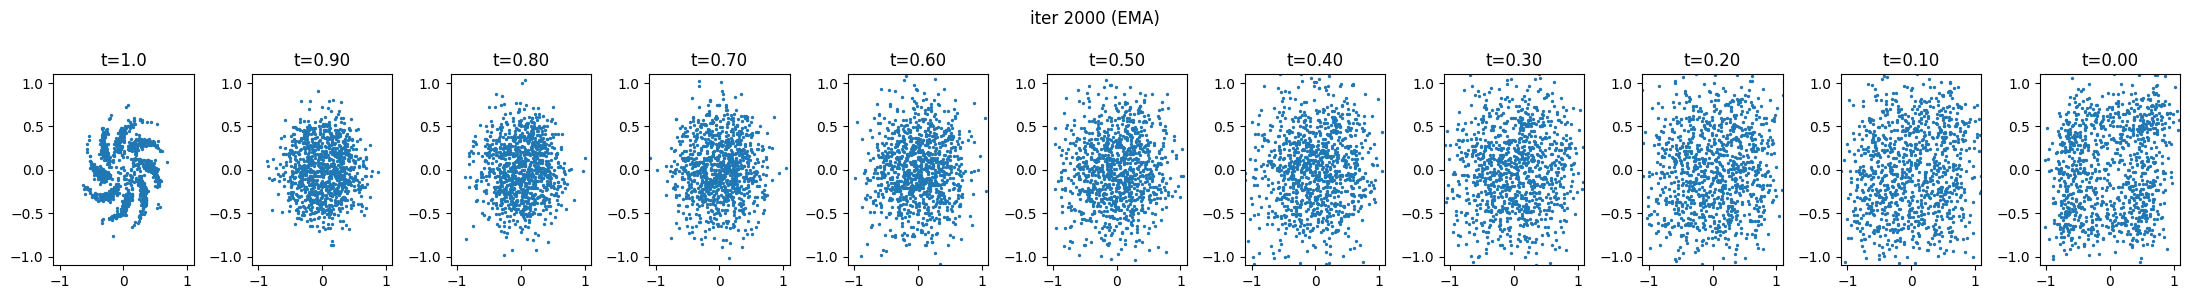

Checkpoint saved @ epoch 2
[Iter 2100] D=1.3889 (real 0.6965 fake 0.6924) | G=0.6968
[Iter 2200] D=1.3867 (real 0.6940 fake 0.6927) | G=0.6946
[Iter 2300] D=1.3884 (real 0.6938 fake 0.6946) | G=0.6927
[Iter 2400] D=1.3859 (real 0.6921 fake 0.6938) | G=0.6940
[Iter 2500] D=1.3869 (real 0.6926 fake 0.6943) | G=0.6942
[Iter 2600] D=1.3852 (real 0.6916 fake 0.6936) | G=0.6961
[Iter 2700] D=1.3870 (real 0.6929 fake 0.6941) | G=0.6931
[Iter 2800] D=1.3844 (real 0.6953 fake 0.6891) | G=0.7006
[Iter 2900] D=1.3883 (real 0.6975 fake 0.6907) | G=0.6973
[Iter 3000] D=1.3880 (real 0.6939 fake 0.6941) | G=0.6921


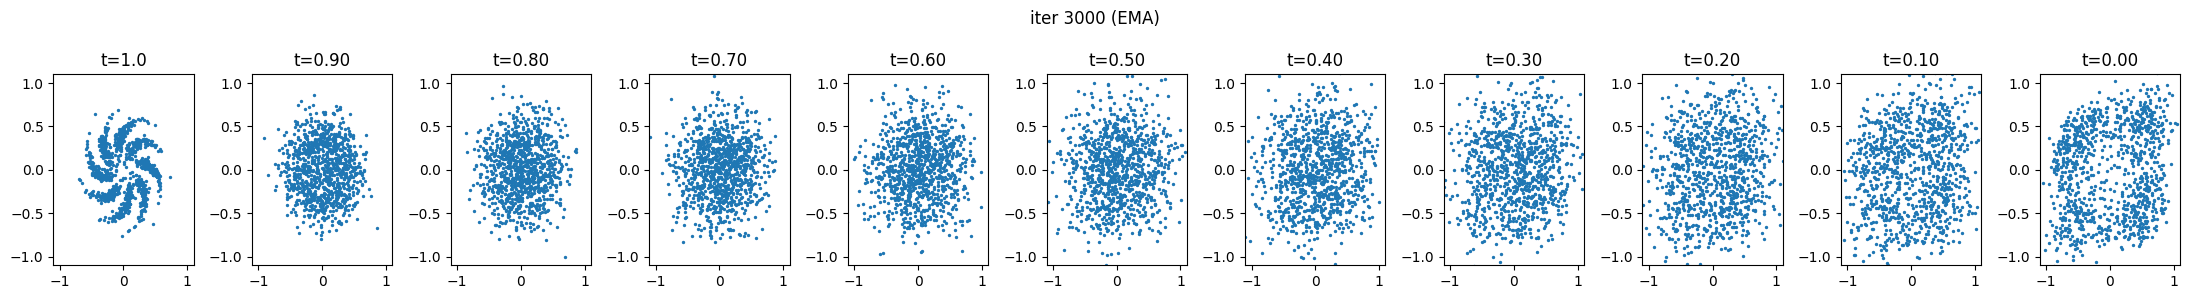

Checkpoint saved @ epoch 3
[Iter 3100] D=1.3843 (real 0.6964 fake 0.6879) | G=0.6998
[Iter 3200] D=1.3899 (real 0.7004 fake 0.6895) | G=0.7026
[Iter 3300] D=1.3869 (real 0.6957 fake 0.6912) | G=0.6982
[Iter 3400] D=1.3891 (real 0.7020 fake 0.6871) | G=0.7015
[Iter 3500] D=1.3860 (real 0.6947 fake 0.6913) | G=0.6977
[Iter 3600] D=1.3850 (real 0.6909 fake 0.6941) | G=0.6953
[Iter 3700] D=1.3894 (real 0.6939 fake 0.6955) | G=0.6947
[Iter 3800] D=1.3855 (real 0.6907 fake 0.6948) | G=0.6926
[Iter 3900] D=1.3873 (real 0.6931 fake 0.6943) | G=0.6915
[Iter 4000] D=1.3897 (real 0.6970 fake 0.6927) | G=0.6974


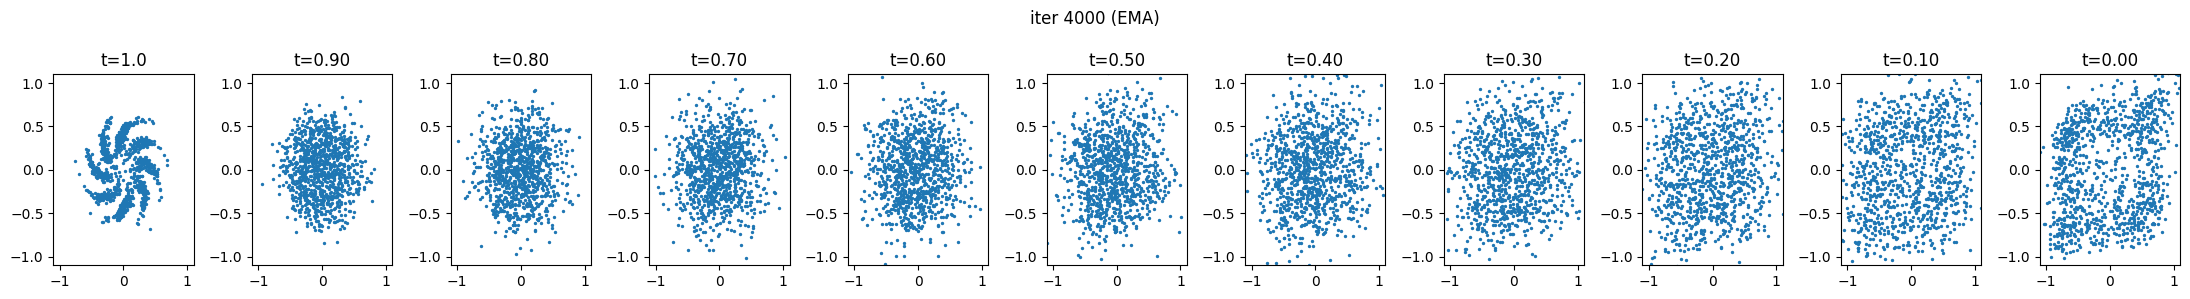

Checkpoint saved @ epoch 4
[Iter 4100] D=1.3883 (real 0.6941 fake 0.6942) | G=0.6934
[Iter 4200] D=1.3871 (real 0.6958 fake 0.6913) | G=0.6941
[Iter 4300] D=1.3903 (real 0.6952 fake 0.6950) | G=0.6936
[Iter 4400] D=1.3865 (real 0.6937 fake 0.6928) | G=0.6922
[Iter 4500] D=1.3865 (real 0.6965 fake 0.6900) | G=0.6956
[Iter 4600] D=1.3878 (real 0.6941 fake 0.6937) | G=0.6949
[Iter 4700] D=1.3869 (real 0.6922 fake 0.6948) | G=0.6915
[Iter 4800] D=1.3884 (real 0.6974 fake 0.6910) | G=0.6967
[Iter 4900] D=1.3832 (real 0.6948 fake 0.6883) | G=0.6988
[Iter 5000] D=1.3885 (real 0.6950 fake 0.6935) | G=0.6933


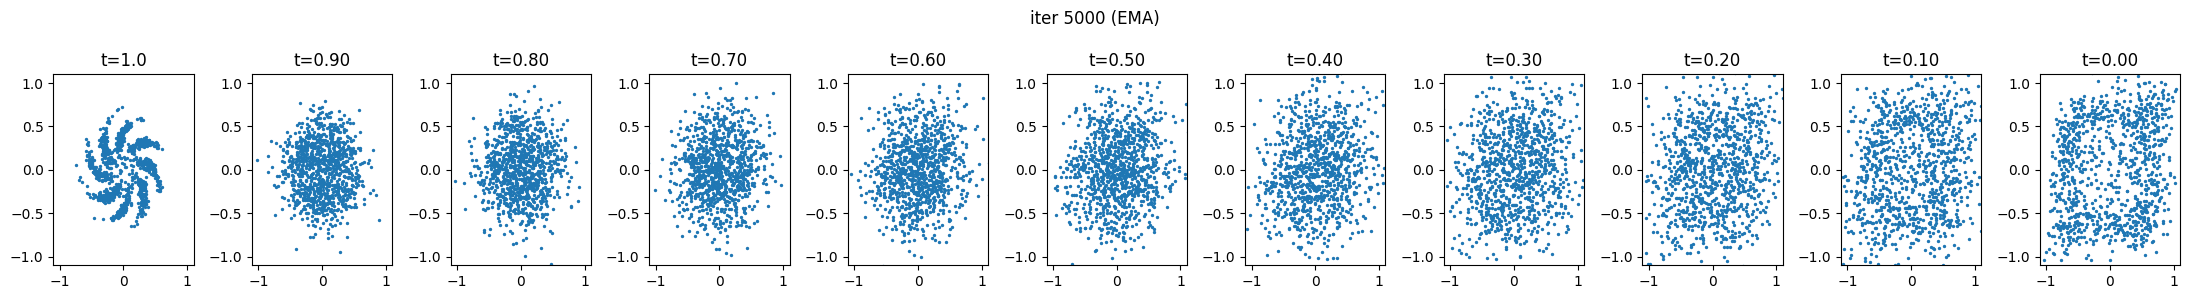

Checkpoint saved @ epoch 5
[Iter 5100] D=1.3850 (real 0.6908 fake 0.6941) | G=0.6937
[Iter 5200] D=1.3861 (real 0.6963 fake 0.6898) | G=0.6978
[Iter 5300] D=1.3893 (real 0.6958 fake 0.6935) | G=0.6937
[Iter 5400] D=1.3871 (real 0.6926 fake 0.6945) | G=0.6933
[Iter 5500] D=1.3891 (real 0.6962 fake 0.6928) | G=0.6943
[Iter 5600] D=1.3886 (real 0.6958 fake 0.6928) | G=0.6936
[Iter 5700] D=1.3885 (real 0.6945 fake 0.6941) | G=0.6923
[Iter 5800] D=1.3862 (real 0.6949 fake 0.6913) | G=0.6961
[Iter 5900] D=1.3856 (real 0.6946 fake 0.6910) | G=0.6951
[Iter 6000] D=1.3864 (real 0.6916 fake 0.6948) | G=0.6923


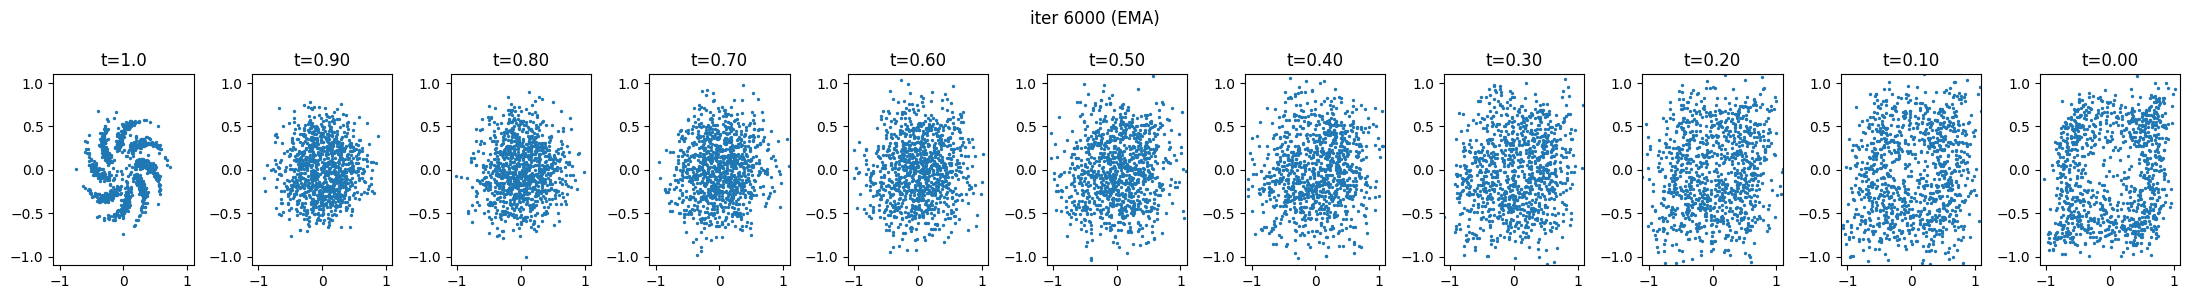

Checkpoint saved @ epoch 6
[Iter 6100] D=1.3882 (real 0.6967 fake 0.6914) | G=0.6958
[Iter 6200] D=1.3859 (real 0.6977 fake 0.6882) | G=0.6984
[Iter 6300] D=1.3895 (real 0.6908 fake 0.6987) | G=0.6881
[Iter 6400] D=1.3858 (real 0.6913 fake 0.6946) | G=0.6925
[Iter 6500] D=1.3874 (real 0.6990 fake 0.6884) | G=0.6986
[Iter 6600] D=1.3875 (real 0.6927 fake 0.6948) | G=0.6903
[Iter 6700] D=1.3854 (real 0.6933 fake 0.6922) | G=0.6948
[Iter 6800] D=1.3859 (real 0.6958 fake 0.6900) | G=0.6953
[Iter 6900] D=1.3863 (real 0.6906 fake 0.6957) | G=0.6913
[Iter 7000] D=1.3853 (real 0.6939 fake 0.6914) | G=0.6945


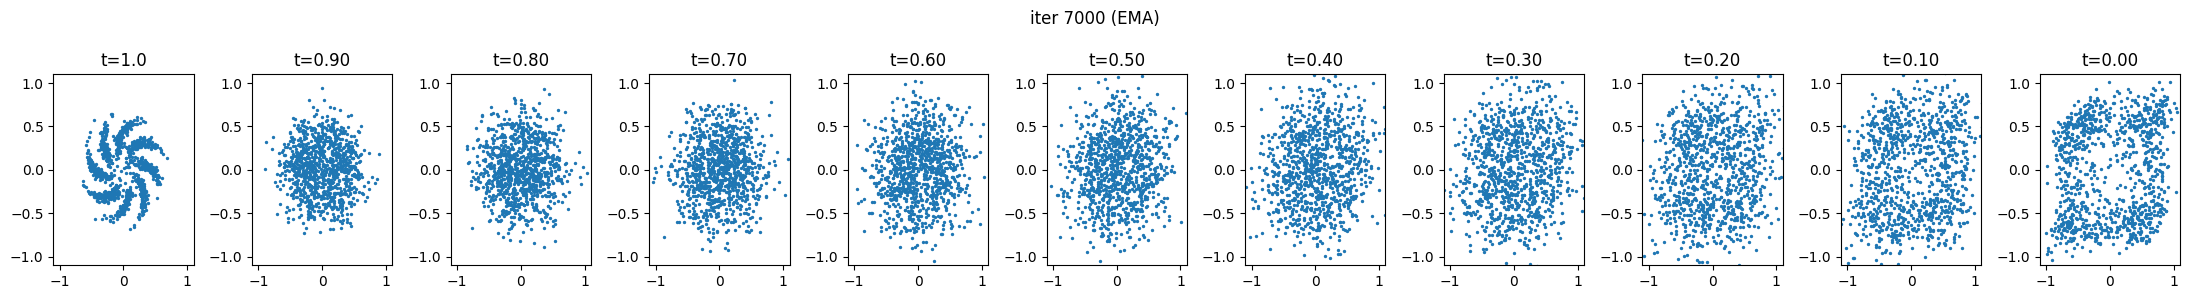

Checkpoint saved @ epoch 7
[Iter 7100] D=1.3853 (real 0.7003 fake 0.6850) | G=0.7009
[Iter 7200] D=1.3871 (real 0.6940 fake 0.6930) | G=0.6961
[Iter 7300] D=1.3863 (real 0.7025 fake 0.6838) | G=0.7034
[Iter 7400] D=1.3859 (real 0.6974 fake 0.6885) | G=0.6968
[Iter 7500] D=1.3872 (real 0.6960 fake 0.6912) | G=0.6951
[Iter 7600] D=1.3862 (real 0.6904 fake 0.6957) | G=0.6922
[Iter 7700] D=1.3869 (real 0.6881 fake 0.6988) | G=0.6875
[Iter 7800] D=1.3859 (real 0.6988 fake 0.6871) | G=0.6973
[Iter 7900] D=1.3861 (real 0.6924 fake 0.6936) | G=0.6914
[Iter 8000] D=1.3867 (real 0.6870 fake 0.6996) | G=0.6874


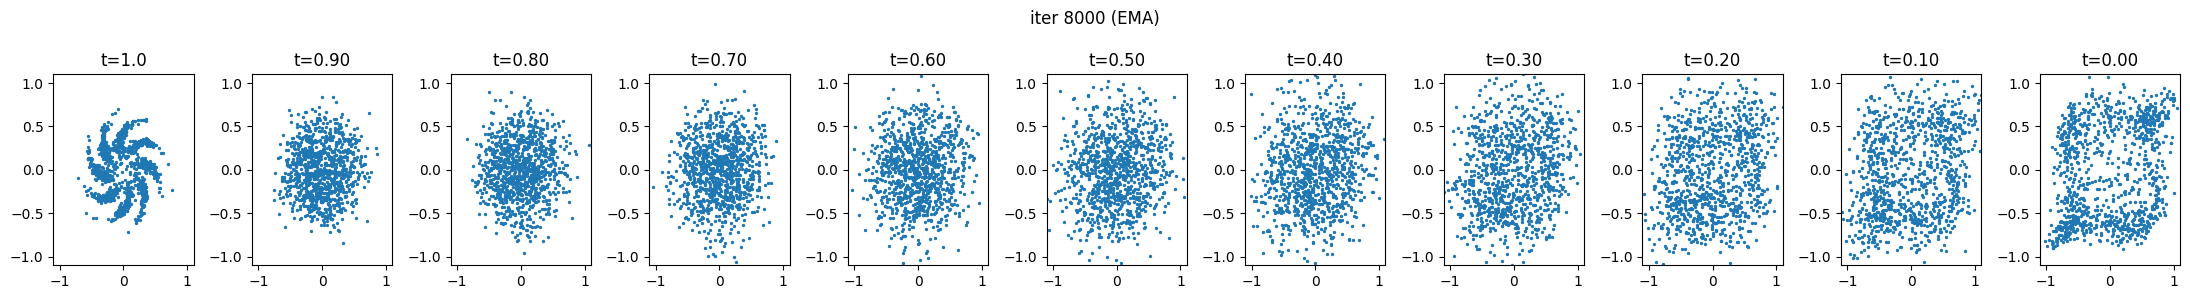

Checkpoint saved @ epoch 8
[Iter 8100] D=1.3860 (real 0.6931 fake 0.6929) | G=0.6935
[Iter 8200] D=1.3868 (real 0.6964 fake 0.6904) | G=0.6965
[Iter 8300] D=1.3857 (real 0.6866 fake 0.6991) | G=0.6879


In [ ]:
def train(args):
    set_seed(args.seed)
    os.makedirs(args.output_dir, exist_ok=True)

    # ==== Brownian posterior coefficients ====
    coefficients = BrownianPosterior_Coefficients(args, device)
    
    # ==== Models ====
    netG = MyGenerator(
        x_dim=args.x_dim,
        t_dim=args.t_dim,
        n_t=args.num_timesteps,
        z_dim=args.z_dim,
        out_dim=args.x_dim,
        layers=[256,256,256],
    ).to(device)
    netD = MyDiscriminator(
        x_dim=args.x_dim,
        t_dim=args.t_dim,
        n_t=args.num_timesteps,
        layers=[256,256,256],
    ).to(device)

    if args.use_ema:
        from torch_ema import ExponentialMovingAverage
        ema_g = ExponentialMovingAverage(netG.parameters(), decay=args.ema_decay)
        ema_g.to(device)
        print(f"Using EMA with decay = {args.ema_decay}")
    else:
        ema_g = None
        print("Not using EMA")

    # ==== Opt & Sched ====
    optimizerD = optim.Adam(netD.parameters(), lr=args.lr_d, betas=(args.beta1, args.beta2))
    optimizerG = optim.Adam(netG.parameters(), lr=args.lr_g, betas=(args.beta1, args.beta2))
    schedulerD = optim.lr_scheduler.CosineAnnealingLR(optimizerD, T_max=args.epoch, eta_min=1e-6)
    schedulerG = optim.lr_scheduler.CosineAnnealingLR(optimizerG, T_max=args.epoch, eta_min=1e-6)

    # ==== (Optional) resume ====
    init_iteration = 0
    checkpoint_path = os.path.join(args.output_dir, 'checkpoint.pth')
    if args.resume and os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        netG.load_state_dict(checkpoint['netG_dict'])
        optimizerG.load_state_dict(checkpoint['optimizerG'])
        schedulerG.load_state_dict(checkpoint['schedulerG'])
        netD.load_state_dict(checkpoint['netD_dict'])
        optimizerD.load_state_dict(checkpoint['optimizerD'])
        schedulerD.load_state_dict(checkpoint['schedulerD'])
        init_iteration = checkpoint['iteration']
        print(f"=> loaded checkpoint (iteration {init_iteration})")
    else:
        if args.resume:
            print(f"=> no checkpoint found at {checkpoint_path}, training from scratch")
        else:
            print(f"=> training from scratch")

    # ==== Paired dataloader for SB ====
    paired_ds = PairedDataset(
        target_class=Checkerboard,
        source_class=Pinwheel,
        # target_kwargs={'grid_size': 8},
        target_kwargs={},
        source_kwargs={},
        size=args.batch_size * 1000,
        pairing="independent"
    )
    sb_loader = DataLoader(
        paired_ds, batch_size=args.batch_size, shuffle=True,
        num_workers=0, pin_memory=True, drop_last=True,
        persistent_workers=False
    )
    
    n_t = args.num_timesteps
    # ==== utils ====
    softplus = F.softplus

    def r1_penalty(d_out, x_in, gamma=0.05):
        grad = torch.autograd.grad(
            outputs=d_out.sum(), inputs=x_in, create_graph=True,
            retain_graph=True, only_inputs=True
        )[0]
        grad_penalty = (grad.view(grad.size(0), -1).norm(2, dim=1) ** 2).mean()
        return 0.5 * gamma * grad_penalty

    # ==== Train loop ====
    iteration = init_iteration
    print("Start training ASBM...")
    
    for epoch in range(args.epoch):
        for x0, x1 in sb_loader:
            netG.train(); netD.train()
            x0 = x0.to(device, non_blocking=True)   # 目标端点 p0（checkerboard）
            x1 = x1.to(device, non_blocking=True)   # 源端点 p1（pinwheel）
            B  = x0.size(0)

            # （可选）批内 OT 重配
            if args.use_minibatch_ot:
                # TODO
                # 直接报错
                raise NotImplementedError("Minibatch OT coupling is not implemented yet.")
            
            #########################
            # Discriminator training
            #########################
            for p in netD.parameters():
                p.requires_grad = True
                
            netD.zero_grad()

            # 采样时间步 - D专用
            t = torch.randint(0, n_t, (B,), device=device, dtype=torch.long)
            
            # 真对
            x_t_real, x_tp1_real = sample_pair_condition(coefficients, x0, x1, t)
            x_t_real.requires_grad = True  # 用于R1
            
            D_real = netD(x_t_real, t, x_tp1_real.detach()).view(-1)
            errD_real = softplus(-D_real).mean()

            # R1正则化
            r1_loss = torch.tensor(0., device=device)
            if args.use_r1 and (iteration % args.lazy_reg == 0):
                r1_loss = r1_penalty(D_real, x_t_real, gamma=args.r1_gamma)
            
            (errD_real + r1_loss).backward()
            
            with torch.no_grad():
                latent_z = torch.randn(B, args.z_dim, device=device)
                x0_predict = netG(x_tp1_real, t, latent_z)
                x_t_fake = sample_posterior(coefficients, x0_predict, x_tp1_real, t)
            
            D_fake = netD(x_t_fake, t, x_tp1_real.detach()).view(-1)
            errD_fake = softplus(D_fake).mean()
            errD_fake.backward()

            errD = errD_real + errD_fake
            nn.utils.clip_grad_norm_(netD.parameters(), max_norm=1.0)
            optimizerD.step()
            
            #########################
            # Generator training
            #########################
            for p in netD.parameters():
                p.requires_grad = False
            
            netG.zero_grad()

            # 重新采样时间步
            t = torch.randint(0, n_t, (B,), device=device, dtype=torch.long)
            
            # 重新生成训练对
            _, x_tp1 = sample_pair_condition(coefficients, x0, x1, t)
            
            latent_z = torch.randn(B, args.z_dim, device=device)
            x0_predict = netG(x_tp1.detach(), t, latent_z)
            x_t_fake = sample_posterior(coefficients, x0_predict, x_tp1, t)
            
            output = netD(x_t_fake, t, x_tp1.detach()).view(-1)
            errG = softplus(-output).mean()
            
            errG.backward()
            
            # 梯度裁剪（可选）
            nn.utils.clip_grad_norm_(netG.parameters(), max_norm=1.0)
            
            optimizerG.step()

            # ⭐ 更新EMA
            if args.use_ema:
                ema_g.update()
            
            iteration += 1
            
            if args.print and (iteration % args.print_interval == 0):
                print(f"[Iter {iteration}] D={errD.item():.4f} "
                      f"(real {errD_real.item():.4f} fake {errD_fake.item():.4f}) | "
                      f"G={errG.item():.4f}")
                
            # 可视化（从源出发逆推到目标）
            if args.vis and iteration % args.vis_interval == 0:
                netG.eval()  # 设为eval模式
                
                # 如果使用EMA，用EMA权重；否则用当前权重
                if args.use_ema:
                    with ema_g.average_parameters():
                        with torch.no_grad():
                            visualize_samples(netG, coefficients, args, x1, n_t, iteration, device)
                else:
                    with torch.no_grad():
                        visualize_samples(netG, coefficients, args, x1, n_t, iteration, device)
                
                netG.train()  # 恢复train模式


        # 每个 epoch 调度 & 保存
        schedulerD.step(); schedulerG.step()
        # ⭐ 保存checkpoint（使用EMA权重）
        if args.save_ckpt:
            if args.use_ema:
                with ema_g.average_parameters():
                    content = {
                        'iteration': iteration,
                        'epoch': epoch,
                        'netG_dict': netG.state_dict(),
                        'optimizerG': optimizerG.state_dict(),
                        'schedulerG': schedulerG.state_dict(),
                        'netD_dict': netD.state_dict(),
                        'optimizerD': optimizerD.state_dict(),
                        'schedulerD': schedulerD.state_dict(),
                    }
            else:
                content = {
                    'iteration': iteration,
                    'epoch': epoch,
                    'netG_dict': netG.state_dict(),
                    'optimizerG': optimizerG.state_dict(),
                    'schedulerG': schedulerG.state_dict(),
                    'netD_dict': netD.state_dict(),
                    'optimizerD': optimizerD.state_dict(),
                    'schedulerD': schedulerD.state_dict(),
                }
            
            torch.save(content, os.path.join(args.output_dir, 'checkpoint.pth'))
            print(f"Checkpoint saved @ epoch {epoch+1}")


args = parse_args(usedefault=True)
args.print = True
args.vis = True
args.save_ckpt = True
args.use_ema = True
args.resume = False
print(args)
train(args)
